# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
from PIL import Image
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision.models.detection import fcos
from torchvision.transforms import v2 as v2
from tqdm.auto import tqdm, trange

import bb
import models
import tt

LOG = logging.getLogger(__name__)
tt.logging_init()

SEED = 325
tt.seed(SEED)

In [ ]:
data_path = Path.home() / "src/data"
mc_data_path = data_path / "minecraft/info.json"
dset = bb.Dataset.load(mc_data_path)
torch_root = data_path / "torchvision"
ckpt_root = data_path / "checkpoints"

In [ ]:
BATCH_SIZE = 16
TRAIN_PCT = .85

ckpt_file = str(ckpt_root / "checkpoint.pt")
mcd_root = data_path / "coco/minecraft"
mcd = bb.MCDataset(mcd_root)
train_dset, valid_dset = tt.split1(mcd, TRAIN_PCT, SEED)
# bb.plot_bb_grid(images, targets, mcd.categories)

train_loader = DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
val_loader = DataLoader(
    valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(train_dset)}, n_valid={len(valid_dset)}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
n_train=346, n_valid=62


# Utils

In [ ]:
def show_batch_preds(
    trainer: models.FCOSTrainer,
    data_loader: DataLoader,
    k: int = 5,
) -> Image.Image:
    images, targets = next(iter(data_loader))
    preds = trainer.forward(images)
    lens = [len(p["scores"]) for p in preds]
    print(f"Preds lengths: {lens}")
    preds = trainer.topk_preds(preds, k=k)
    return bb.plot_bb_grid(images, preds, mcd.categories, include_scores=True, nrow=2)

# Experiment Log

## Experiments

### exp1 - classification head only, He init
- cls_head_only_he_init_10ep.pt
- 10 epochs, lr=1e-4
- mAP: 0.0014
- loss looked great, detections terrible

### exp2 - classification head only, FCOS init  
- cls_head_only_fcos_init_8ep.pt
- 10 epochs, lr=1e-4
- mAP: 0.0554
- loss looked worse but 40x better mAP

### exp3 - full head unfrozen, FCOS init
- lr=1e-4
- 10 epochs - mAP: 0.2784 - full_head_10ep.pt
- 20 epochs - mAP: 0.3189 - full_head_20ep.pt
- 40 epochs - mAP: 0.3511 - full_head_40ep.pt   * Best
- 50 epochs - mAP: 0.3235 - full_head_50ep.pt
- Much better

### exp4 - full head unfrozen, He init
- mAP - 0.0013
- 10 epochs, lr=1e-4
- Still bad

### exp5 - full head unfrozen, FCOS init, lr=1e-3
- lr=1e-3
- 20 epochs - mAP: 0.3208 - full_head_lr3_20ep.pt
- 40 epochs - mAP: 0.3264 - full_head_lr3_40ep.pt

### Future experiments are all FCOS init

### exp6 - full head unfrozen, aug
 - v2.RandomHorizontalFlip(p=0.5), ColorJitter(brightness=0.2, contrast=0.2),
 - 20 epochs - lr=1e-4 mAP=0.2906 - aug_lr4_20ep.pt
 - 40 epochs - switch to lr=5e-4 loss=0.7192 mAP=0.3307 - aug_lr4_40ep.pt

### exp7 - manually var lr
- lr 1e-3 for 10, lr 1e-4 for 20, lr 5e-5 for 10
- epochs=10 loss=1.0806 mAP=0.2636
- epochs=30 loss=0.8719 mAP=0.3528
- epochs=40 loss=0.7976 mAP=0.3608

### exp 8 - ReduceLROnPlateau
- Final epochs=40 loss=0.7257 mAP=0.3546

### exp 9 - ReduceLROnPlateau - same with save best
- New best mAP=0.3566 at epoch 31
- Final epochs=60 loss=0.6600 mAP=0.3351

### exp 10 - CosineAnnealingWarmRestarts

# Experiments

## Exp 1

In [ ]:
he_init_ckpt = ckpt_root / f"cls_head_only_he_init_{NUM_EPOCHS}ep.pt"

# e_he_init = models.FCOSTrainer(categories=mcd.categories, he_init=True)
# e_he_init.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# e_he_init.save_checkpoint(he_init_ckpt)

# e_he_init = models.FCOSTrainer(
#     categories=mcd.categories, he_init=True, checkpoint=he_init_ckpt
# )

## Exp 2

In [ ]:
fcos_init_ckpt = ckpt_root / f"cls_head_only_fcos_init_{NUM_EPOCHS}ep.pt"

# e_fcos_init = models.FCOSTrainer(categories=mcd.categories, he_init=False)
# e_fcos_init.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# e_fcos_init.save_checkpoint(fcos_init_ckpt)

# e_fcos_init = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=fcos_init_ckpt
# )

## Exp 3

In [ ]:
TRAINER = models.FCOSTrainer(categories=mcd.categories, he_init=False)
START_CKPT = ckpt_root / f"full_head_40ep.pt"
END_CKPT = ckpt_root / f"full_head_50ep.pt"

# TRAINER.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(CKPT)

TRAINER = models.FCOSTrainer(
    categories=mcd.categories, he_init=False, checkpoint=START_CKPT
)
TRAINER.train(train_loader=train_loader, val_loader=val_loader, num_epochs=10)
TRAINER.save_checkpoint(END_CKPT)

# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
TRAINER.plot_loss(label="Exp 3")
TRAINER.plot_eval(label="Exp 3")

In [ ]:
epoch_range = (30, None)
TRAINER.plot_loss(epoch_range=epoch_range, show=True)
TRAINER.plot_eval(epoch_range=epoch_range)

## Exp 5

In [ ]:
START_EPOCH = 20
END_EPOCH = 40
NUM_EPOCHS = END_EPOCH - START_EPOCH
TRAINER = models.FCOSTrainer(categories=mcd.categories, he_init=False)
START_CKPT = ckpt_root / f"full_head_lr3_{START_EPOCH}ep.pt"
END_CKPT = ckpt_root / f"full_head_lr3_{END_EPOCH}ep.pt"

# Train new
# TRAINER.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=START_CKPT
# )
# TRAINER.train(train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Load and plot
TRAINER = models.FCOSTrainer(
    categories=mcd.categories, he_init=False, checkpoint=END_CKPT
)
TRAINER.plot_loss(label="Exp 5")
TRAINER.plot_eval(label="Exp 5")

In [ ]:
show_batch_preds(TRAINER, val_loader, k=5)

In [ ]:
epoch_range = (-20, None)
TRAINER.plot_loss(epoch_range=epoch_range, show=True)
TRAINER.plot_eval(epoch_range=epoch_range)

## Exp 6

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

START_EPOCH = 20
END_EPOCH = 40
LR = 1e-4
EPOCH_PREFIX = "aug_lr4"

NUM_EPOCHS = END_EPOCH - START_EPOCH
START_CKPT = ckpt_root / f"{EPOCH_PREFIX}_{START_EPOCH}ep.pt"
END_CKPT = ckpt_root / f"{EPOCH_PREFIX}_{END_EPOCH}ep.pt"

aug_mcd = bb.MCDataset(mcd_root, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(mcd, TRAIN_PCT, SEED)
aug_valid_dset.transform = None
# bb.plot_bb_grid(images, targets, mcd.categories)

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories, he_init=False, lr=LR)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
LR = 5e-5
TRAINER = models.FCOSTrainer(
    categories=mcd.categories, he_init=False, checkpoint=START_CKPT, lr=LR
)
TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
TRAINER.save_checkpoint(END_CKPT)

# Load and plot
# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
# TRAINER.plot_loss(label="Exp 5")
# TRAINER.plot_eval(label="Exp 5")

In [ ]:
show_batch_preds(TRAINER, aug_val_loader, k=5)

## Exp 7

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

START_EPOCH = 30
END_EPOCH = 40
EPOCH_PREFIX = "exp7"

NUM_EPOCHS = END_EPOCH - START_EPOCH
START_CKPT = ckpt_root / f"{EPOCH_PREFIX}_{START_EPOCH}ep.pt"
END_CKPT = ckpt_root / f"{EPOCH_PREFIX}_{END_EPOCH}ep.pt"

aug_mcd = bb.MCDataset(mcd_root, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(mcd, TRAIN_PCT, SEED)
aug_valid_dset.transform = None

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# LR = 1e-3
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories, he_init=False, lr=LR)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# LR = 1e-4
LR = 5e-5
TRAINER = models.FCOSTrainer(
    categories=mcd.categories, he_init=False, checkpoint=START_CKPT, lr=LR
)
TRAINER.train(
    train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS
)
TRAINER.save_checkpoint(END_CKPT)

# Load and plot
# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
# TRAINER.plot_loss(label="Exp 5")
# TRAINER.plot_eval(label="Exp 5")

In [ ]:
show_batch_preds(TRAINER, aug_val_loader, k=1)

## Exp 8

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
n_train=346, n_valid=62
Loading checkpoint: /Users/joe/src/data/checkpoints/exp8_60ep.pt
err_keys = <All keys matched successfully>


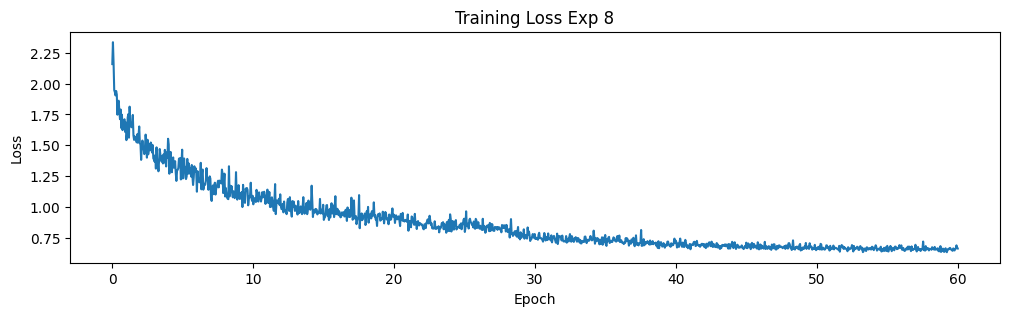

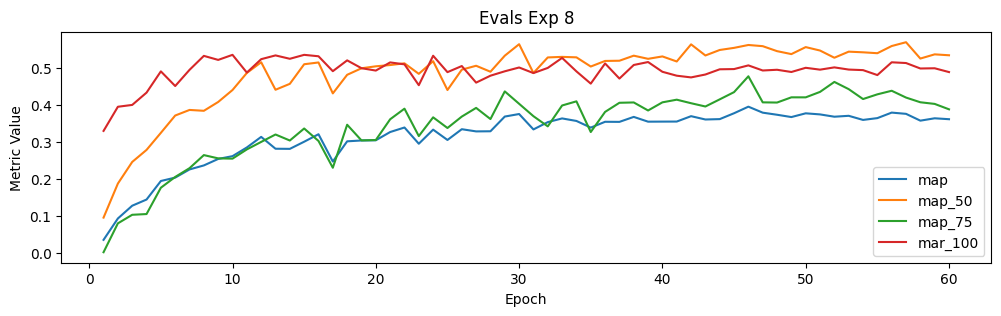

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

START_EPOCH = 40
END_EPOCH = 60
EPOCH_PREFIX = "exp8"

NUM_EPOCHS = END_EPOCH - START_EPOCH
START_CKPT = ckpt_root / f"{EPOCH_PREFIX}_{START_EPOCH}ep.pt"
END_CKPT = ckpt_root / f"{EPOCH_PREFIX}_{END_EPOCH}ep.pt"
BEST_CKPT = ckpt_root / f"{EPOCH_PREFIX}_best.pt"

aug_mcd = bb.MCDataset(mcd_root, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(mcd, TRAIN_PCT, SEED)
aug_valid_dset.transform = None

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# TRAINER = models.FCOSTrainer(categories=mcd.categories, checkpoint=START_CKPT)
# TRAINER.train(
#     train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS
# )
# TRAINER.save_checkpoint(END_CKPT)

# Load and plot
TRAINER = models.FCOSTrainer(categories=mcd.categories, checkpoint=END_CKPT)
TRAINER.plot_loss(label="Exp 8", show=True)
TRAINER.plot_eval(label="Exp 8")

## Exp9

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
n_train=346, n_valid=62
Loading checkpoint: /Users/joe/src/data/checkpoints/exp9_60ep.pt
err_keys = <All keys matched successfully>


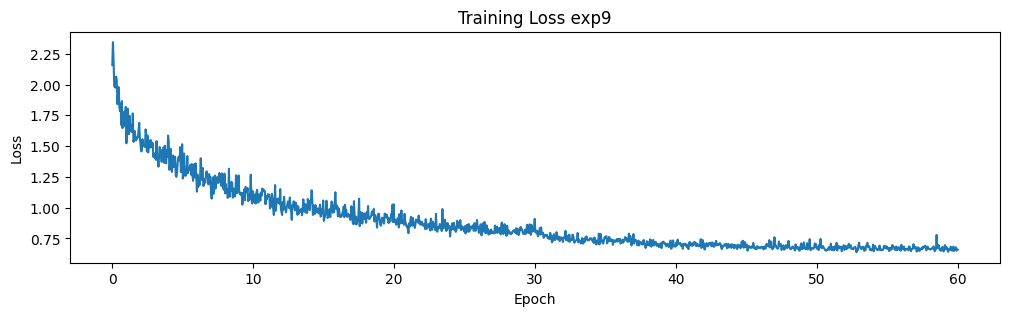

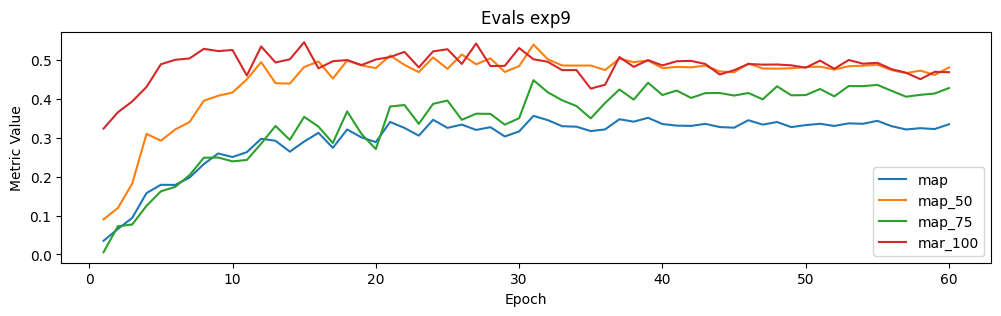

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

START_EPOCH = 0
END_EPOCH = 60
EPOCH_PREFIX = "exp9"

NUM_EPOCHS = END_EPOCH - START_EPOCH
START_CKPT = ckpt_root / f"{EPOCH_PREFIX}_{START_EPOCH}ep.pt"
END_CKPT = ckpt_root / f"{EPOCH_PREFIX}_{END_EPOCH}ep.pt"
BEST_CKPT = ckpt_root / f"{EPOCH_PREFIX}_best.pt"

aug_mcd = bb.MCDataset(mcd_root, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(mcd, TRAIN_PCT, SEED)
aug_valid_dset.transform = None

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories, best_checkpoint=BEST_CKPT)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# TRAINER = models.FCOSTrainer(categories=mcd.categories, checkpoint=START_CKPT, best_checkpoint=BEST_CKPT)
# TRAINER.train(
#     train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS
# )
# TRAINER.save_checkpoint(END_CKPT)

# Load and plot
TRAINER = models.FCOSTrainer(categories=mcd.categories, checkpoint=END_CKPT)
TRAINER.plot_loss(label=EPOCH_PREFIX, show=True)
TRAINER.plot_eval(label=EPOCH_PREFIX)

Loading checkpoint: /Users/joe/src/data/checkpoints/exp9_best.pt
err_keys = <All keys matched successfully>
Preds lengths: [12, 9, 11, 5, 6, 12, 7, 11, 22, 13, 13, 3, 4, 20, 11, 29]


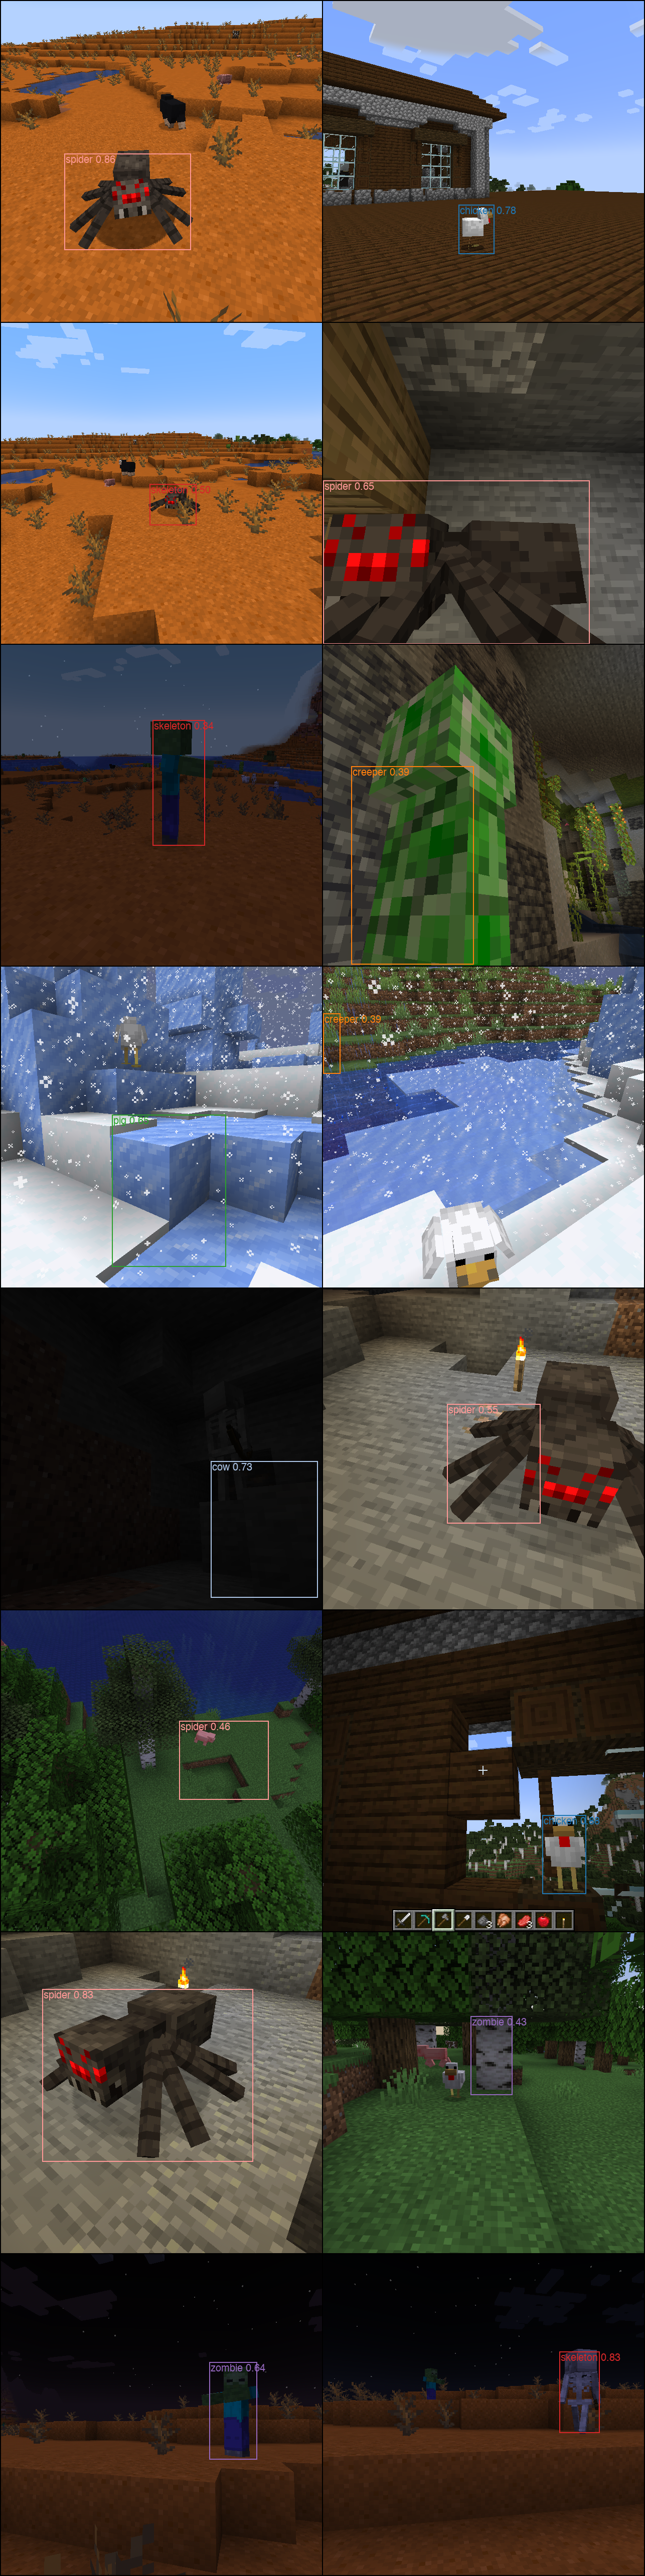

In [19]:

# TRAINER = models.FCOSTrainer(
#     categories=mcd.categories, he_init=False, checkpoint=END_CKPT
# )
trainer = models.FCOSTrainer(categories=mcd.categories, checkpoint=BEST_CKPT)
show_batch_preds(trainer, val_loader, k=1)

## Exp10

In [ ]:


transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

START_EPOCH = 0
END_EPOCH = 60
EPOCH_PREFIX = "exp9"

NUM_EPOCHS = END_EPOCH - START_EPOCH
START_CKPT = ckpt_root / f"{EPOCH_PREFIX}_{START_EPOCH}ep.pt"
END_CKPT = ckpt_root / f"{EPOCH_PREFIX}_{END_EPOCH}ep.pt"
BEST_CKPT = ckpt_root / f"{EPOCH_PREFIX}_best.pt"

aug_mcd = bb.MCDataset(mcd_root, transform=transform)
aug_train_dset, aug_valid_dset = tt.split1(mcd, TRAIN_PCT, SEED)
aug_valid_dset.transform = None

aug_train_loader = DataLoader(
    aug_train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
aug_val_loader = DataLoader(
    aug_valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(aug_train_dset)}, n_valid={len(aug_valid_dset)}")

# Train new
# TRAINER = models.FCOSTrainer(categories=aug_mcd.categories, best_checkpoint=BEST_CKPT)
# TRAINER.train(train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS)
# TRAINER.save_checkpoint(END_CKPT)

# Continue from previous
# TRAINER = models.FCOSTrainer(categories=mcd.categories, checkpoint=START_CKPT, best_checkpoint=BEST_CKPT)
# TRAINER.train(
#     train_loader=aug_train_loader, val_loader=aug_val_loader, num_epochs=NUM_EPOCHS
# )
# TRAINER.save_checkpoint(END_CKPT)

# Load and plot
TRAINER = models.FCOSTrainer(categories=mcd.categories, checkpoint=END_CKPT)
TRAINER.plot_loss(label=EPOCH_PREFIX, show=True)
TRAINER.plot_eval(label=EPOCH_PREFIX)

# Scratch

In [ ]:
# Test checkpoint
t0 = models.FCOSTrainer(categories=mcd.categories)
t0.save_checkpoint(ckpt_root / "t0.ckpt")
t1 = models.FCOSTrainer(categories=mcd.categories, checkpoint=ckpt_root / "t0.ckpt")
models.compare_models(t0.model, t1.model)

In [ ]:
img_ix = 20
e_fcos_init.plot_infer(mcd[img_ix][0], topk=5)

In [ ]:
images, targets = next(iter(train_loader))
bb.plot_bb_grid(images, targets, mcd.categories)

In [ ]:
trainer = models.FCOSTrainer(categories=mcd.categories, he_init=False, checkpoint=ckpt_root / "full_head_40ep.pt" )
show_batch_preds(trainer, val_loader)

In [ ]:
trainer = models.FCOSTrainer(
    categories=mcd.categories, checkpoint=ckpt_root / "full_head_lr3_20ep.pt"
)
show_batch_preds(trainer, val_loader)

# Augmentation tests

In [ ]:
transform = v2.Compose(
    [
        v2.RandomHorizontalFlip(p=0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2),
        # v2.RandomZoomOut(side_range=(1.0, 1.5)),
    ]
)

In [ ]:
import torchvision.transforms.v2.functional as Fv2

image, target = mcd[0]

# Apply to image and boxes together
image, target = transform(image, target)
print(image.shape)
# Fv2.to_pil_image(image)
bb.torch_plot_bb(image, target, categories=mcd.categories, return_pil=True)

In [ ]:
aug_mcd = bb.MCDataset(mcd_root, transform=transform)
image, target = aug_mcd[0]
bb.torch_plot_bb(image, target, categories=mcd.categories, return_pil=True)

In [ ]:
aug_mcd[0]